##### Set up packages and directories

In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
import random
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import HMM as hmm
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment_HMM as alignment_hmm
from Comparative_Analysis import Alignment_Analysis as alignment_analysis
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import Master_Alignment_HMM as master_alignment_hmm
from Comparative_Analysis import Multi_Species_Master_Alignment_HMM as multi_species_master_alignment_hmm
from Comparative_Analysis import Arneson_Ernst_HMM as ae_hmm
import random
import copy
from joblib import Parallel, delayed
import os
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML
import matplotlib as mpl

In [2]:
project_dir = 'D:/Project_Data/Project_6'
genome_datasets_dir = project_dir + '/Datasets/NCBI_Datasets'
literature_datasets_dir = project_dir + '/Datasets/Data_From_Publications'
cryptic_output_path = "D:/Project_Data/CRYPTIC_DATA/Cryptic_Data_Analysis"
cryptic_input_path = "D:/Project_Data/CRYPTIC_DATA/"
output_dir = project_dir + '/Output'
refseq_dir = 'D:/NCBI_Dataset_Mycobacteria'
protein_fasta_output_loc = output_dir + '/Protein_Sequences'
outgroup_protein_fasta_output_loc = output_dir + '/Protein_Sequences_With_Outgroup'
sonic_paranoid_run_name = 'Run_Without_Outgroup'
outgroup_sonic_paranoid_run_name = 'Run_With_Outgroup'
sonic_paranoid_output_loc = output_dir + '/Sonic_Paranoid_Output'
ortholog_dir = sonic_paranoid_output_loc + '/runs/' + sonic_paranoid_run_name + '/ortholog_groups'
outgroup_ortholog_dir = sonic_paranoid_output_loc + '/runs/' + outgroup_sonic_paranoid_run_name + '/ortholog_groups'
non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Downstream_Non_CDS'
upstream_non_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Upstream_Non_CDS'
cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS'
extended_cds_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_CDS'
extended_non_cds_regions_output_dir = output_dir + '/Multiple_Alignment_Data/Extended_Non_CDS'
outgroup_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup'
outgroup_concatenated_cds_output_dir = output_dir + '/Multiple_Alignment_Data/CDS_With_Outgroup_Concatenated'
hmm_parameters_output_dir = output_dir +'/HMM_Model_Parameters'
conservation_analysis_output_dir = output_dir + '/Conservation_Analysis'
num_cores = 16
core_numbers = list(range(1, num_cores+1))

In [3]:
species_list = util.list_dirs(refseq_dir)
print(len(species_list))

205


##### Translation function

In [4]:
codon_dict = {}
with open('D:/Project_Data/Project_3/Datasets/Reference_Tables/Standard_Code.txt') as f:
    for l in f:
        codon_dict[str(l[1:4])] = l[5]

In [5]:
def translate_sequence(input_seq, strand, rf):
    output_seq = ''
    if strand == 1:
        seq = input_seq[rf:]
    else:
        seq = align.reverse_complement(input_seq)[rf:]
    for i in range(0,len(seq)-2,3):
        if seq[i:(i+3)] in codon_dict:
            output_seq += codon_dict[seq[i:(i+3)]]
        else:
            output_seq += 'X'
    return output_seq

In [6]:
def translate_orf(start, end, strand):
    return translate_sequence(full_sequence[start:end], strand, 0)              

In [7]:
def parse_genome(num_subsets, subset_num, id_list):
    ids = util.chunk_list(id_list, num_subsets, subset_num)
    temp = []
    for id in ids:
        temp_1 = []
        genome_record = next(SeqIO.parse(refseq_dir + '/' + id + '/genomic.gbff', "genbank"))
        organism_name = genome_record.annotations['organism']
        full_sequence = str(genome_record.seq)

        for feature in genome_record.features:
            a = feature.qualifiers
            if a.get("protein_id") != None and a.get("locus_tag")!= None and a.get("translation")!= None:
                if a.get("note")!= None:
                    note = a.get("note")[0]
                else:
                    note = ''
                if a.get("product")!= None:
                    product = a.get("product")[0]
                else:
                    product = ''
                locus_tag = a.get("locus_tag")[0]
                protein_id = a.get("protein_id")[0]
                temp_1.append([feature.type, int(feature.location.start), int(feature.location.end), int(feature.location.strand), note, product, locus_tag, protein_id])
        temp.append([id, temp_1])
    return temp

In [8]:
parallel_output = Parallel(n_jobs=-1)(delayed(parse_genome)(num_cores, core_number, species_list) for core_number in core_numbers)
temp = [item for sublist in parallel_output for item in sublist]
all_genome_feature_dict = {}
for entry in temp:
    all_genome_feature_dict[entry[0]] = entry[1]

In [9]:
def find_annotation(species, start, end):
    info = all_genome_feature_dict[species]
    a = ''
    overlap = 0
    in_frame = False
    for items in info:
        if min(items[2], max(start, end)) - max(items[1], min(start,end))  > 0.4 * (items[2] - items[1]):
            a = items
            strand = items[3]
            overlap = (min(items[2], max(start,end)) - max(items[1], min(start,end)))/(items[2] - items[1])
            if (strand == 1 and (items[1] - start)%3 == 0)  or (strand == -1 and (items[2] - 1 - start)%3 ==0):    #Python end index is +1 from actual end
                in_frame = True
            else:
                in_frame = False
            break
    return a, overlap, in_frame
            

##### Output nt sequences in FASTA format

In [10]:
def produce_nt_blast_file(record_list, output_filename):
    with open(output_filename, 'w',  newline='') as outfile:
        line_length = 60
        for record in tqdm(record_list):
            sequence = record[1]
            lines = []
            sequence_length = len(sequence)
            number_of_lines = math.ceil(sequence_length / line_length)
            lines.append(">" +record[0]+ "\n")
            for i in range(number_of_lines):
                subsequence = sequence[i*line_length:(i+1)*line_length]
                lines.append(subsequence + "\n")
            outfile.write(''.join(lines))

##### Mycobrowser is used for CDS demarcation, sequence is taken from GCF_000195955.2

In [11]:
genome_record = next(SeqIO.parse(genome_datasets_dir + '/GCF_000195955.2/genomic.gbff', "genbank"))
full_sequence = genome_record.seq

In [12]:
locus_info_dict = {}
tb_cds_dict = {}
tb_all_feature_dict = {}
actual_cds_boundaries = []
mycobrowser_df = pd.read_excel(literature_datasets_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Function']]      #Just CDS
temp_all_features = mycobrowser_df[['Locus','Start','Stop','Strand','Function']]     #All features
actual_cds_boundaries = []
actual_all_feature_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    actual_cds_boundaries.append((r['Locus'],r['Start']-1, r['Stop'], strand))
    tb_cds_dict[r['Locus']] = (r['Start']-1, r['Stop'], strand)
    locus_info_dict[r['Locus']] = r['Function']
for i, r in temp_all_features.iterrows():
    if r['Strand'] == '+':
        strand = 1
    else:
        strand = -1
    actual_all_feature_boundaries.append((r['Locus'],r['Start']-1, r['Stop'], strand))
    tb_all_feature_dict[r['Locus']] = (r['Start']-1, r['Stop'], strand)

##### Load variant dataset and create variant dictionary (0 indexed for genome position - whereas CRyPtiC data uses 1 start)

In [13]:
variant_count_df = pd.read_csv(cryptic_output_path + '/filtered_variant_summary_df.csv')
variant_count_df = variant_count_df[variant_count_df['MUTATION_PCT'] < 0.1]

In [14]:
temp = variant_count_df.groupby(['GENOME_INDEX'])[['MYKROBE_LINEAGE_NAME_2']].count().reset_index()
temp_dict = dict(zip(temp.GENOME_INDEX, temp.MYKROBE_LINEAGE_NAME_2))

In [15]:
mutation_counts_dict = {}
for i in tqdm(range(len(full_sequence))):
    if (i+1) in temp_dict:
        mutation_counts_dict[i] = temp_dict[(i+1)]
    else:
        mutation_counts_dict[i] = 0

  0%|          | 0/4411532 [00:00<?, ?it/s]

##### Define binomial probabilities for testing mutation counts

In [16]:
def bin_formula(max_bin_counts, tot_bin_counts, in_frame = False):
    return 1- binom.cdf(max_bin_counts-1, tot_bin_counts,1/3)

In [17]:
def mutation_bin_probability(start, end, strand):
    mutations = []
    for i in range(start,end):
        for j in range(mutation_counts_dict[i]):
            mutations.append(i)
    bin_counts = [0,0,0]
    for m in mutations:
        if strand == 1:
            bin_counts[(m-(start))%3] +=1
        else:
            bin_counts[((end-1)-m)%3] +=1
    if sum(bin_counts) == 0:
        return (2)
    else:
        return (bin_formula(bin_counts[2], sum(bin_counts)))  

##### Function to find maximal open reading frame between two co-ordinates with mutation probability less than defined p-value

In [21]:
def find_all_orfs(seq_start, seq_stop, p_value, output_all_orfs = False, min_orf_length = 0):
    max_len = 0
    orfs_found = []
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (full_sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(full_sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for rf in range(3):
            i = rf
            while i < seq_len - 2:
                orf_length = 0
                test_codon = temp[i: i+3] 
                if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
                    for j in range(i + 3, seq_len - 2, 3):
                        test_codon_2 = temp[j: j+3] 
                        if test_codon_2 in ['TAG','TGA','TAA']:
                            orf_length = j - i
                            break
                            
                if orf_length > 0:
                    if frame == 'Forward':
                        orf_start =  seq_start + i
                        orf_end = seq_start + j+3
                        orf_strand = 1
                    else:
                        orf_start =  seq_start + seq_len-(j+3)
                        orf_end = seq_start + seq_len-i
                        orf_strand = -1
                    prob = mutation_bin_probability(orf_start, orf_end, orf_strand)
                    if prob < p_value and orf_length >= min_orf_length:
                        orfs_found.append((orf_start, orf_end, orf_strand, orf_length, prob))

                if orf_length > max_len and prob< p_value and orf_length >= min_orf_length:                                           
                    max_len = orf_length
                    start_pos = orf_start
                    end_pos = orf_end
                    strand = orf_strand 

                
                i +=3
    if output_all_orfs == True:
        sorted_orfs = sorted(orfs_found, key=lambda x: x[3], reverse=True)
        return sorted_orfs                
    elif start_pos == -999:
        return(0,0,0)
    else:
        return(start_pos, end_pos, strand, max_len, mutation_bin_probability(start_pos, end_pos, strand))   

In [18]:
def find_all_maximal_orfs(seq_start, seq_stop, p_value, output_all_orfs = False, min_orf_length = 0):
    max_len = 0
    orfs_found = []
    start_pos = -999
    end_pos = -999
    for frame in ['Forward', 'Reverse']:
        if frame == 'Forward':
            temp = (full_sequence[seq_start: seq_stop])
        else:
            temp = align.reverse_complement(full_sequence[seq_start: seq_stop])
        seq_len = len(temp)
        for rf in range(3):
            i = rf
            while i < seq_len - 2:
                orf_length = 0
                test_codon = temp[i: i+3] 
                if test_codon in ['ATG','GTG','TTG']:  #Missed out CTG as doesn't seem to be used very much at all
                    for j in range(i + 3, seq_len - 2, 3):
                        test_codon_2 = temp[j: j+3] 
                        if test_codon_2 in ['TAG','TGA','TAA']:
                            orf_length = j - i
                            break
                            
                if orf_length > 0:
                    if frame == 'Forward':
                        orf_start =  seq_start + i
                        orf_end = seq_start + j+3
                        orf_strand = 1
                    else:
                        orf_start =  seq_start + seq_len-(j+3)
                        orf_end = seq_start + seq_len-i
                        orf_strand = -1
                    prob = mutation_bin_probability(orf_start, orf_end, orf_strand)
                    if prob < p_value and orf_length >= min_orf_length:
                        orfs_found.append((orf_start, orf_end, orf_strand, orf_length, prob))

                if orf_length > max_len and prob< p_value and orf_length >= min_orf_length:                                           
                    max_len = orf_length
                    start_pos = orf_start
                    end_pos = orf_end
                    strand = orf_strand 

                if orf_length > 0:
                    i = j
                else:
                    i +=3
    if output_all_orfs == True:
        sorted_orfs = sorted(orfs_found, key=lambda x: x[3], reverse=True)
        return sorted_orfs                
    elif start_pos == -999:
        return(0,0,0)
    else:
        return(start_pos, end_pos, strand, max_len, mutation_bin_probability(start_pos, end_pos, strand))   

##### Function for generic blasting of ORF list

In [161]:
def blast_orfs(orf_details_list, output_file_loc):
    putative_protein_dict = {}
    putative_proteins = []
    for i, orf_details in enumerate(orf_details_list):
        a = translate_orf(orf_details[0], orf_details[1], orf_details[2])
        putative_proteins.append(['seq_'+str(i), a[:-1]])
        putative_protein_dict['seq_'+str(i)] = orf_details
    produce_nt_blast_file(putative_proteins, refseq_dir + '/temp_protein.faa')
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\BLAST\\myco_refseq_nt & tblastn -query d:\\NCBI_Dataset_Mycobacteria\\temp_protein.faa -db myco_refseq_nt -out tblastn_results.csv -evalue 0.001 -seg no -outfmt "10 qaccver saccver pident length mismatch gapopen qstart qend sstart send sstrand evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    os.chdir(w_d)

    blast_results = pd.read_csv("D:\\BLAST\\myco_refseq_nt\\tblastn_results.csv", header = None)
    blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'subject_strand', 'e_value', 'bit_score']
    blast_results = blast_results.groupby('query_accession_ver').filter(lambda x: x['query_accession_ver'].count() >= 10)
    blast_results['info']=  blast_results['query_accession_ver'].map(putative_protein_dict)
    blast_results[['start_coord', 'end_coord', 'strand', 'q_length', 'prob']] = pd.DataFrame(blast_results['info'].tolist(), index=blast_results.index)
    blast_results['subject_start_alignment'] = blast_results['subject_start_alignment'] - 1 #Zero index
    blast_results['alignment_ratio'] = blast_results['alignment_length'] / blast_results['q_length'] * 3
    blast_results['annotation_info'] =''
    blast_results['overlap'] =''
    blast_results['in_frame'] =''
    for i, r in tqdm(blast_results.iterrows(), total=blast_results.shape[0]):
        a, overlap, in_frame =  find_annotation(r['subject_accession_ver'], r['subject_start_alignment'],r['subject_end_alignment'])
        blast_results.at[i, 'annotation_info'] = a
        blast_results.at[i, 'overlap'] = overlap
        blast_results.at[i, 'in_frame'] = in_frame
    blast_results.to_csv(output_file_loc)

##### Take "inter-feature" regions and find maximal ORFs in all frames

In [22]:
maximal_orfs = find_all_maximal_orfs(0, len(full_sequence), 3, True, 60)
all_orfs = find_all_orfs(0, len(full_sequence), 3, True, 60)
any_maximal_orfs = find_all_maximal_orfs(0, len(full_sequence), 3, True, 1)
any_all_orfs = find_all_orfs(0, len(full_sequence), 3, True, 1)

In [23]:
print(len(any_all_orfs), len(all_orfs), len(any_maximal_orfs), len(maximal_orfs))

386076 286055 92618 59882


In [270]:
putative_protein_dict = {}
putative_proteins = []
non_included_boundaries = []
for i, (locus,start,stop,strand) in enumerate(actual_all_feature_boundaries):
    if i==0 or stop >= actual_all_feature_boundaries[i-1][2]:
        non_included_boundaries.append(actual_all_feature_boundaries[i])
for i, (locus,start,stop,strand) in enumerate(non_included_boundaries):
        if i < len(non_included_boundaries) - 1:
            #filtered_orf_details_list = [x for x in maximal_orfs if ((x[2] ==1 and x[1] > stop and x[1] <= non_included_boundaries[i+1][1]) or (x[2] ==-1 and x[0] > stop and x[0] < non_included_boundaries[i+1][1])) and x[4] < 0.001]
            filtered_orf_details_list = find_all_maximal_orfs(stop, non_included_boundaries[i+1][1], 3, output_all_orfs = True, min_orf_length = 200)
            if len(filtered_orf_details_list) > 0:
                last_locus = 'A'
                locus_suffix = 0
                for orf_details in filtered_orf_details_list:
                    a = translate_orf(orf_details[0], orf_details[1], orf_details[2])
                    
                    if locus == last_locus:
                        locus_suffix +=1
                    else:
                        locus_suffix = 0
                    last_locus = locus
                    putative_proteins.append([locus+'_'+str(locus_suffix), a[:-1]])
                    putative_protein_dict[locus+'_'+str(locus_suffix)] = orf_details
produce_nt_blast_file(putative_proteins, refseq_dir + '/putative_protein.faa')

  0%|          | 0/423 [00:00<?, ?it/s]

In [272]:
if 1==1:
    w_d = os.getcwd()
    os.chdir("D:/")
    #subprocess.run('cd d:\\BLAST\\myco_refseq_nt & tblastn -query d:\\NCBI_Dataset_Mycobacteria\\putative_protein.faa -db myco_refseq_nt -out tblastn_results.csv -evalue 0.001 -seg=no  -outfmt 10 -num_threads 16', shell=True, capture_output = True)   
    subprocess.run('cd d:\\BLAST\\myco_refseq_nt & tblastn -query d:\\NCBI_Dataset_Mycobacteria\\putative_protein.faa -db myco_refseq_nt -out tblastn_results.csv -evalue 0.001 -seg no -outfmt "10 qaccver saccver pident length mismatch gapopen qstart qend sstart send sstrand evalue bitscore" -num_threads 16', shell=True, capture_output = True)
    os.chdir(w_d)

In [273]:
blast_results = pd.read_csv("D:\\BLAST\\myco_refseq_nt\\tblastn_results.csv", header = None)
blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'subject_strand', 'e_value', 'bit_score']
#blast_results = blast_results[~blast_results['subject_accession_ver'].isin(['GCF_000195955.2', 'GCF_000253375.1'])]
blast_results = blast_results.groupby('query_accession_ver').filter(lambda x: x['query_accession_ver'].count() >= 10)
blast_results['info']=  blast_results['query_accession_ver'].map(putative_protein_dict)
blast_results[['start_coord', 'end_coord', 'strand', 'q_length', 'prob']] = pd.DataFrame(blast_results['info'].tolist(), index=blast_results.index)
blast_results['subject_start_alignment'] = blast_results['subject_start_alignment'] - 1 #Zero index
blast_results['alignment_ratio'] = blast_results['alignment_length'] / blast_results['q_length'] * 3
blast_results['annotation_info'] =''
blast_results['overlap'] =''
blast_results['in_frame'] =''

In [274]:
for i, r in tqdm(blast_results.iterrows(), total=blast_results.shape[0]):
    a, overlap, in_frame =  find_annotation(r['subject_accession_ver'], r['subject_start_alignment'],r['subject_end_alignment'])
    blast_results.at[i, 'annotation_info'] = a
    blast_results.at[i, 'overlap'] = overlap
    blast_results.at[i, 'in_frame'] = in_frame

  0%|          | 0/8088 [00:00<?, ?it/s]

In [275]:
blast_results.to_csv(project_dir + '/temp.csv')

##### Graph p-values for annotated genes

In [19]:
annotated_cds_probabilities = []
for (locus, start, stop, strand) in tqdm(actual_cds_boundaries):
    annotated_cds_probabilities.append((locus, mutation_bin_probability(start, stop, strand)))

  0%|          | 0/4031 [00:00<?, ?it/s]

In [20]:
maximal_orfs = find_all_maximal_orfs(0, 4411530, 3, output_all_orfs = True, min_orf_length = 80)     #Min length set to capture all orfs in annotation
maximal_orf_dict = {}
for orf in maximal_orfs:
    if orf[2] == 1:
        maximal_orf_dict[(orf[1],1)] = orf      #Need to have strand and stop refs as same location can act as stop on different strands and need separate dictionary entries
    else:
        maximal_orf_dict[(orf[0],-1)] = orf

In [107]:
new_maximal_orfs = copy.deepcopy(maximal_orfs)
for i, (locus, start, stop, strand) in tqdm(enumerate(actual_cds_boundaries)):
    if strand == 1:
        if (stop,1) in maximal_orf_dict:
            maximal_orf = maximal_orf_dict[(stop,1)]
            new_maximal_orfs.remove(maximal_orf) 
    else:
        if (start,-1) in maximal_orf_dict:
            maximal_orf = maximal_orf_dict[(start,-1)]
            new_maximal_orfs.remove(maximal_orf) 

0it [00:00, ?it/s]

In [108]:
print(len(maximal_orfs), len(new_maximal_orfs), len(actual_cds_boundaries))

51627 47600 4031


In [109]:
new_maximal_orfs = [x for x in new_maximal_orfs if x[1]-x[0] > 500]

<AxesSubplot:>

<Figure size 2400x1600 with 0 Axes>

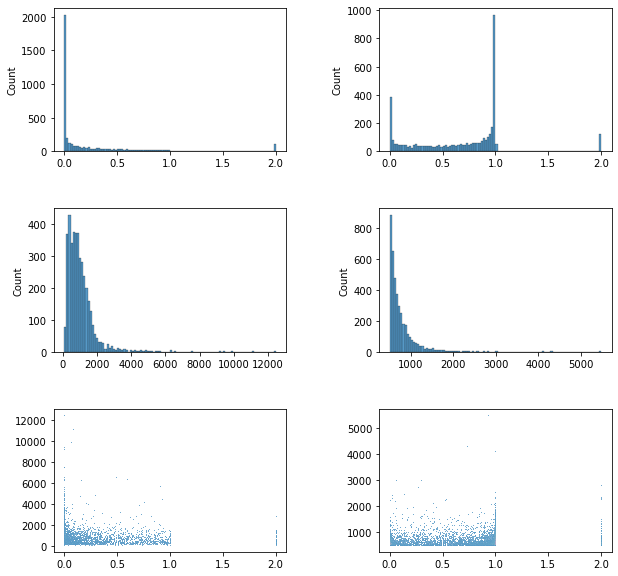

In [110]:
mpl.rcParams['figure.figsize'] = (10,10)
fig=plt.figure(figsize=(24,16), dpi= 100, facecolor='w', edgecolor='k')
fig, axs = plt.subplots(ncols=2, nrows=3)
plt.subplots_adjust(wspace=0.4, hspace=0.4)
annotation_probs = [x[1] for x in annotated_cds_probabilities]
sns.histplot(annotation_probs, bins = 100, ax=axs[0][0])
#plt.xlabel("p-value")
#plt.ylabel("number of genes - Mycobrowser R3 annotation") 
all_max_orf_probs = [x[4] for x in new_maximal_orfs]
all_max_orf_lengths = [x[1]-x[0] for x in new_maximal_orfs]
sns.histplot(all_max_orf_probs, bins = 100, ax = axs[0][1])
actual_cds_lengths = [x[2]-x[1] for x in actual_cds_boundaries]
sns.histplot(actual_cds_lengths, bins = 100, ax = axs[1][0])
sns.histplot(all_max_orf_lengths, bins = 100, ax = axs[1][1])
sns.scatterplot(y=[x[2]-x[1] for x in actual_cds_boundaries],x=[x[1] for x in annotated_cds_probabilities], s=1, ax=axs[2][0])
sns.scatterplot(y=[x[1]-x[0] for x in new_maximal_orfs],x=[x[4] for x in new_maximal_orfs], s=1, ax=axs[2][1])

In [ ]:
candidate_proteins = [x for x in new_maximal_orfs if x[4] < 0.0001]
sns.histplot(x = [y[1]-y[0] for y in candidate_proteins])

In [ ]:
temp = []
temp_dict = {}
for i, orf_details in enumerate(candidate_proteins):
    a = translate_orf(orf_details[0], orf_details[1], orf_details[2])
    temp.append(['ref_'+str(i), a[:-1]])
    temp_dict['ref_'+str(i)] = orf_details
produce_nt_blast_file(temp, refseq_dir + '/putative_protein2.faa')

In [ ]:
if 1==0:
    w_d = os.getcwd()
    os.chdir("D:/")
    subprocess.run('cd d:\\BLAST\\myco_refseq_nt & tblastn -query d:\\NCBI_Dataset_Mycobacteria\\putative_protein2.faa -db myco_refseq_nt -out tblastn_results2.xml -evalue 0.001 -seg=no  -outfmt 10 -num_threads 16', shell=True, capture_output = True)      #-seg=no 
    os.chdir(w_d)

In [ ]:
blast_results = pd.read_csv("D:\\BLAST\\myco_refseq_nt\\tblastn_results2.xml", header = None)
blast_results.columns = ['query_accession_ver', 'subject_accession_ver', 'percent_identical_matches','alignment_length', 'number_mismatches', 'number_of_gap_openings', 'query_start_alignment', 'query_end_alignment', 'subject_start_alignment', 'subject_end_alignment', 'e_value', 'bit_score']
#blast_results = blast_results[~blast_results['subject_accession_ver'].isin(['GCF_000195955.2', 'GCF_000253375.1'])]
blast_results = blast_results.groupby('query_accession_ver').filter(lambda x: x['query_accession_ver'].count() >= 10)
blast_results['info']=  blast_results['query_accession_ver'].map(temp_dict)
blast_results[['start_coord', 'end_coord', 'strand', 'q_length', 'prob']] = pd.DataFrame(blast_results['info'].tolist(), index=blast_results.index)
blast_results['alignment_ratio'] = blast_results['alignment_length'] / blast_results['q_length'] * 3
blast_results['annotation_info'] =''
blast_results['overlap'] =''
blast_results['in_frame'] =''

In [ ]:
for i, r in tqdm(blast_results.iterrows(), total=blast_results.shape[0]):
    a, overlap, in_frame =  find_annotation(r['subject_accession_ver'], r['subject_start_alignment'],r['subject_end_alignment'])
    blast_results.at[i, 'annotation_info'] = a
    blast_results.at[i, 'overlap'] = overlap
    blast_results.at[i, 'in_frame'] = in_frame

In [ ]:
blast_results.to_csv(project_dir + '/temp2.csv')

##### Identify function percentage in Unknown between high and low p-value regions

In [ ]:
locus_exceptions = [x[0] for x in annotated_cds_probabilities if (x[1] > 0.5 and x[1] < 1.1)]
num_unknown_exceptions = 0
for ex in locus_exceptions:
    if 'nknown' in locus_info_dict[ex]:
        num_unknown_exceptions += 1
tot_locus = [x[0] for x in annotated_cds_probabilities]
num_unknown_tot = 0
for ex in tot_locus:
    if ex in locus_info_dict:
        if len(str(locus_info_dict[ex])) > 4:
            if 'nknown' in locus_info_dict[ex]:
                num_unknown_tot += 1
print(num_unknown_exceptions, len(locus_exceptions))
print(num_unknown_tot, len(tot_locus))
print(num_unknown_exceptions/len(locus_exceptions), (num_unknown_tot-num_unknown_exceptions)/(len(tot_locus)-len(locus_exceptions)))

In [184]:
temp_boundaries = []
orf_details_list = []
for i, (locus,start,stop,strand) in enumerate(actual_all_feature_boundaries):          #Don't include ones which are nested as this causes a problem when defining 'inter feature region'
    if i==0 or stop >= actual_all_feature_boundaries[i-1][2]:
        temp_boundaries.append(actual_all_feature_boundaries[i])
for i, (locus,start,stop,strand) in enumerate(temp_boundaries):
        if i < len(temp_boundaries) - 1:
            orf_details = max_orf(stop, temp_boundaries[i+1][1], 3, output_all_orfs = True, min_orf_length = 150)
            for orf in orf_details:
                orf_details_list.append(orf)

In [186]:
x = [a for a in orf_details_list if a[4] < 0.01]

In [188]:
blast_orfs(orf_list, project_dir + '/nick.csv')

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/2501 [00:00<?, ?it/s]

In [235]:
filter_orf_list(max_orf(1173000, 1177000, 3, True, 200))

[(1174100, 1175114, 1, 1011, 0.9486854847661296),
 (1173900, 1174869, -1, 966, 0.1971100429295679),
 (1173012, 1173786, 1, 771, 0.051047277387002876),
 (1173944, 1174700, -1, 753, 0.4433978520326465),
 (1174994, 1175654, -1, 657, 0.8111435026972302),
 (1176029, 1176485, 1, 453, 0.0869118032330285),
 (1176418, 1176814, -1, 393, 0.4149604202186732),
 (1175722, 1176112, 1, 387, 0.9500143964739406),
 (1176565, 1176904, 1, 336, 0.45824124051459214),
 (1173607, 1173904, -1, 294, 0.8703976026242365),
 (1176217, 1176502, 1, 282, 0.9886997139729382),
 (1175488, 1175773, -1, 282, 0.40594619602907533),
 (1175460, 1175736, 1, 273, 0.30451427273420517),
 (1176010, 1176286, -1, 273, 0.30207837207675636),
 (1174926, 1175199, -1, 270, 0.7236709452177368),
 (1176593, 1176860, 1, 264, 0.12466550278029875),
 (1174105, 1174366, 1, 258, 0.031126503877213385),
 (1175991, 1176225, -1, 231, 0.09970365022631322),
 (1175171, 1175381, 1, 207, 0.7088448046066158),
 (1175660, 1175870, 1, 207, 0.14564064924488318)]

In [24]:
maximal_orfs = find_all_maximal_orfs(0, len(full_sequence), 3, True, 0)

In [25]:
len(maximal_orfs)

92618

In [37]:
from tabulate import tabulate
data =[]
for morf in maximal_orfs[0:10]:
    for cds in actual_cds_boundaries:
        if morf[0] <= cds[1] and morf[1] >= cds[2] and morf[2] == cds[3] and (morf[1]-cds[2])%3 == 0:
            data.append([morf, cds])
print (tabulate(data, headers=["mORF_Info", "CDS_Info"]))

mORF_Info                                             CDS_Info
----------------------------------------------------  ---------------------------------
(2294530, 2306986, -1, 12453, 7.771561172376096e-16)  ('Rv2048c', 2294530, 2306986, -1)
(3755951, 3767315, -1, 11361, 0.10794931590069845)    ('Rv3350c', 3755951, 3767102, -1)
(424776, 434679, -1, 9900, 0.05937825140099218)       ('Rv0355c', 424776, 434679, -1)
(3743710, 3753184, -1, 9471, 0.0008519361235744816)   ('Rv3347c', 3743710, 3753184, -1)
(2840122, 2849332, -1, 9207, 0.0)                     ('Rv2524c', 2840122, 2849332, -1)
(3729363, 3736935, -1, 7569, 5.5181768376932894e-08)  ('Rv3343c', 3729363, 3736935, -1)
(109976, 117539, 1, 7560, 3.3306690738754696e-16)     ('Rv0101', 110000, 117539, 1)
(366149, 373334, -1, 7182, 0.32845670404001526)       ('Rv0304c', 366149, 372764, -1)
(3255684, 3262251, 1, 6564, 1.1102230246251565e-16)   ('Rv2933', 3255684, 3262251, 1)
(1875303, 1881684, 1, 6378, 0.5889534566655156)       ('Rv1661', 18

In [26]:
optimality = []
for cds in actual_cds_boundaries:
    x = [(y,(cds[2]-cds[1])/(y[1]-y[0]))  for y in maximal_orfs if y[0] <= cds[1] and y[1] >= cds[2] and y[2] == cds[3] and (y[1]-cds[2])%3 == 0]
    optimality.append((cds, x))

In [27]:
optimality[233][1][0][1]

0.929384965831435

<AxesSubplot:ylabel='Count'>

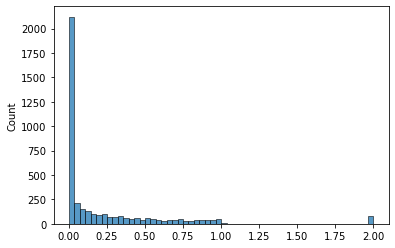

In [28]:
probs = []
opt = []
for o in optimality:
   
    if len(o[1]) > 0:
        probs.append(o[1][0][0][4])
        opt.append(o[1][0][1])
sns.histplot(probs)

<AxesSubplot:ylabel='Count'>

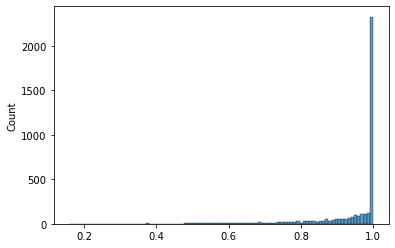

In [29]:
sns.histplot(opt)

<AxesSubplot:>

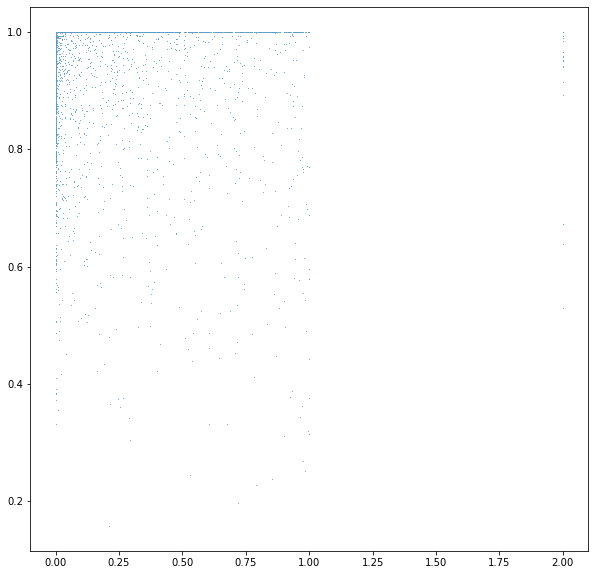

In [310]:
sns.scatterplot(x=probs, y=opt, s=1)

In [30]:
maximal_orfs[0:5]

[(2294530, 2306986, -1, 12453, 7.771561172376096e-16),
 (3755951, 3767315, -1, 11361, 0.10794931590069845),
 (424776, 434679, -1, 9900, 0.05937825140099218),
 (3743710, 3753184, -1, 9471, 0.0008519361235744816),
 (2840122, 2849332, -1, 9207, 0.0)]